In [1]:
from cdlib import algorithms, evaluation
from cdlib import TemporalClustering

In [48]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import networkx as nx

In [4]:
import pickle

In [5]:
#Per plottare le communities per dimensione
def plot_communities_dimentions(coms):
    myd = {}
    for t in coms:
        lunghezza = len(t)

        if str(lunghezza) in myd:
            myd[str(lunghezza)] = myd[str(lunghezza)] + 1
        else:
            myd[str(lunghezza)] = 1

    print(myd)
    plt.figure(figsize=(20,5))
    plt.bar(myd.keys(), myd.values(), color='b')

In [6]:
coms_months = []
for i in range(12):
    with open(f'CommunityDiscovery/communities_{i}.pickle', 'rb') as f:
        louvain_coms = pickle.load(f)
    coms_months.append(louvain_coms)

In [7]:
for i in coms_months:
    
    max_c=0
    for com in i.communities:
        if(len(com)>max_c):
            max_c = len(com)
    print(str(len(i.communities)) + " - " + str(max_c))

56 - 889
49 - 572
40 - 567
48 - 600
54 - 580
53 - 519
45 - 571
39 - 532
39 - 444
38 - 384
41 - 374
41 - 350


In [8]:
tc = TemporalClustering()
for t in range(12):
    tc.add_clustering(coms_months[t], t)

In [9]:
tc.get_observation_ids()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Una semplice misura della stabilità temporale è il "clustering stability trend" <br>
Dato come input un TemporalClustering e un punteggio di somiglianza delle partizioni (ad esempio, NMI, NF1...) tale trend descrive quante partizioni tendono a rimanere le stesse con il passare del tempo.

L'indice di stabilità viene calcolato per coppie di cluster temporalmente adiacenti.

In [155]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.011268988798526927,
 0.012863895558223285,
 0.013032670454545455,
 0.012792803768680958,
 0.018884968723901076,
 0.015707058001397625,
 0.010484330484330484,
 0.02177514792899408,
 0.019532855808159447,
 0.009858793324775352,
 0.011968366168597123]

Poiché il nostro obiettivo è trasformare un algoritmo statico in uno dinamico, una volta calcolati i clustering dobbiamo abbinarli tra id temporali consecutivi.

In [11]:
tc.has_explicit_match()

False

Dall'approccio personalizzato non è venuto fuori però un abbinamento esplicito.
Si definisce una funzione di somiglianza (prendendo come input due set e restituendo un valore float) per eseguire tale corrispondenza intertemporale

In [12]:
# una funzione di similarità il cui co-dominio è in [0, 1]
jaccard = lambda x, y: len(set(x) & set(y)) / len(set(x) | set(y))

Successivamente possiamo applicarlo alla nostra partizione temporale, specificando se deve essere applicato solo dal passato al futuro (un lato) o anche dal futuro al passato (due lati).

Il primo scenario consente di identificare eventi di merge, il secondo anche di split.

In [13]:
matches = tc.community_matching(jaccard, two_sided=True)

community_matching restituisce una lista di tuple della forma: <br>
                (Ti_Ca, Tj_Cb, score) <br>
I nomi di comunità vengono assegnati seguendo lo schema {tid}_{cid}, dove tid è il tempo di osservazione e cid è la posizione della comunità all'interno dell'oggetto Clustering.

Una volta ottenuta la corrispondenza tra le comunità, possiamo calcolare il loro grafo del ciclo di vita: un polytree diretto che rappresenta la trasformazione della comunità nel tempo.

In [14]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=True)

In [15]:
edges = list(com_polytree.edges(data=True))

In [23]:
edges[0]

('0_0', '1_0', {'weight': 0.20943708609271522})

In [18]:
new = com_polytree.edge_subgraph([edges[0][0:2]]).copy()

In [22]:
new.edges(data=True)

OutEdgeDataView([('0_0', '1_0', {'weight': 0.20943708609271522})])

In [24]:
selelected_edges = []

In [25]:
for i in edges:
    if i[2]["weight"] > 0:
        selelected_edges.append(i[0:2])
new_polytree = com_polytree.edge_subgraph(selelected_edges).copy()

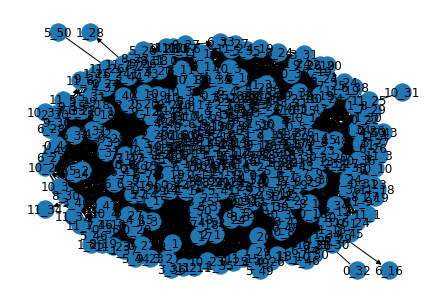

In [28]:
for nodes in nx.weakly_connected_components(new_polytree):
    sub =  com_polytree.subgraph(nodes)
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True)

In [38]:
n_nodes = []
month_com = []
for i in list(new_polytree.nodes()):
    month_com.append(int(i.split("_")[0]))
    n_nodes.append(i)

In [46]:
s_edges = []
t_edges = []
for i in list(new_polytree.edges()):
    s_edges.append(i[0])
    t_edges.append(i[1])

In [49]:
new_df = pd.DataFrame({"Id": n_nodes, "month": month_com})
new_df.to_csv("nodes.csv", index=False)

In [50]:
new_df = pd.DataFrame({"Source": s_edges, "Target": t_edges})
new_df.to_csv("edges.csv", index=False)

In [64]:
nx.write_graphml(new_polytree, "polytree_threshold.graphml")

In [52]:
def birth(nodes, edges):
    n_birth = 0
    birth_nodes = []
    for node in nodes:
        is_birth = True
        for edge in edges:
            if node == edge[1]:
                is_birth = False
                break
        if is_birth:
            n_birth+=1
            birth_nodes.append(node)
    return n_birth, birth_nodes

In [53]:
def death(nodes, edges):
    n_death = 0
    death_nodes = []
    for node in nodes:
        is_death = True
        for edge in edges:
            if node == edge[0]:
                is_death = False
                break
        if is_death:
            n_death+=1
            death_nodes.append(node)
    return n_death, death_nodes

In [54]:
def merge(nodes, edges):
    n_merge = 0
    merge_nodes = {}
    for node in nodes:
        tmp_from = []
        n_from = 0
        for edge in edges:
            if node == edge[1]:
                tmp_from.append(edge[0])
                n_from+=1
        if n_from >1:
            n_merge+=1
            merge_nodes[node]=tmp_from
    return n_merge, merge_nodes

In [55]:
def split(nodes, edges):
    n_split = 0
    split_nodes = {}
    for node in nodes:
        tmp_to = []
        n_to = 0
        for edge in edges:
            if node == edge[0]:
                tmp_to.append(edge[1])
                n_to+=1
        if n_to >1:
            n_split+=1
            split_nodes[node]=tmp_to
    return n_split, split_nodes

In [138]:
def continue_(nodes, edges):
    n_continue = 0
    continue_nodes = []
    for node in nodes:
        n_to = 0
        tmp_to = ""
        for edge in edges:
            if node == edge[0]:
                tmp_to=edge[1]
                n_to+=1
        if n_to ==1:
            n_in = 0
            for edge in edges:
                if edge[1] == tmp_to:
                    n_in+=1
            if n_in ==1:
                n_continue+=1
                continue_nodes.append((node, tmp_to))
    return n_continue, continue_nodes

In [120]:
def type_continue(continue_nodes, tc):
    grow = 0
    contraction = 0
    grow_ll = []
    contraction_ll = []
    for u,v in continue_nodes:
        u_  = u.split("_")
        v_  = v.split("_")
        com_u = tc.get_clustering_at(int(u_[0])).named_communities[u]
        com_v = tc.get_clustering_at(int(v_[0])).named_communities[v]
        l_u = len(com_u)
        l_v = len(com_v)
        if l_u < l_v:
            grow+=1
            grow_ll.append((u, v))
        if l_u > l_v:
            contraction+=1
            contraction_ll.append((u, v))
    return grow, contraction, grow_ll, contraction_ll

In [148]:
def resourge(nodes, edges, tc):
    #nodes without exit edges
    no_exit_nodes = []
    for node in nodes:
        no_exit = True
        for edge in edges:
            if node == edge[0]:
                no_exit = False
                break
        if no_exit:
            no_exit_nodes.append(node)
    #nodes withou entry edges
    no_entry_nodes = []
    for node in nodes:
        no_entry = True
        for edge in edges:
            if node == edge[1]:
                no_entry = False
                break
        if no_entry:
            no_entry_nodes.append(node)
    #for all no_exit (at t):
    #       if there is a no_entry (at t + n) == no_exit (at t)
    #              resourge found
    resourge = 0
    resourge_ll = []
    for n_ex in no_exit_nodes:
        clust_ex, commu_ex = n_ex.split("_")
        for n_en in no_entry_nodes:
            clust_en, commu_en = n_en.split("_")
            if int(clust_en) > int(clust_ex):
                # from t to t+n
                com_ex = tc.get_clustering_at(int(clust_ex)).named_communities[n_ex]
                com_en = tc.get_clustering_at(int(clust_en)).named_communities[n_en]
                com_ex.sort()
                com_en.sort()
                if com_ex == com_en:
                    resourge+=1
                    resourge_ll.append((n_ex, n_en))
    return resourge, resourge_ll

In [58]:
nodes_polytree = list(com_polytree.nodes())
edges_polytree = list(com_polytree.edges())

In [61]:
print(len(nodes_polytree))
print(len(edges_polytree))

543
12502


In [65]:
nodes_new = list(new_polytree.nodes())
edges_new = list(new_polytree.edges())

In [66]:
print(len(nodes_new))
print(len(edges_new))

423
514


In [67]:
for i in new_polytree.edges(data=True):
    print(i)

('0_0', '1_0', {'weight': 0.20943708609271522})
('0_0', '1_26', {'weight': 0.0011235955056179776})
('1_0', '2_0', {'weight': 0.19142259414225943})
('1_0', '2_34', {'weight': 0.0017452006980802793})
('0_1', '1_2', {'weight': 0.19195979899497487})
('0_1', '1_19', {'weight': 0.002607561929595828})
('0_1', '1_24', {'weight': 0.00261437908496732})
('1_2', '2_4', {'weight': 0.14664586583463338})
('1_2', '2_17', {'weight': 0.002347417840375587})
('0_2', '1_1', {'weight': 0.16942148760330578})
('0_2', '1_35', {'weight': 0.001584786053882726})
('0_2', '1_37', {'weight': 0.001584786053882726})
('1_1', '2_1', {'weight': 0.20672478206724781})
('0_3', '1_4', {'weight': 0.16716867469879518})
('0_3', '1_36', {'weight': 0.004357298474945534})
('1_4', '2_3', {'weight': 0.1771019677996422})
('0_4', '1_5', {'weight': 0.08426073131955485})
('0_4', '1_17', {'weight': 0.004694835680751174})
('1_5', '2_6', {'weight': 0.10067114093959731})
('0_5', '1_7', {'weight': 0.05432937181663837})
('1_7', '2_8', {'weigh

In [70]:
n_birth, birth_nodes = birth(nodes_polytree, edges_polytree)
print(n_birth)

56


In [71]:
n_death, death_nodes = death(nodes_polytree, edges_polytree)
print(n_death)

41


In [72]:
n_merge, merge_nodes = merge(nodes_polytree, edges_polytree)
print(n_merge)

487


In [73]:
n_split, split_nodes = split(nodes_polytree, edges_polytree)
print(n_split)

502


In [139]:
n_continue, continue_nodes = continue_(nodes_polytree, edges_polytree)
print(n_continue)

0


In [75]:
if n_continue > 0:
    n_grow, n_contraction = type_continue(continue_nodes, tc)
    print("N grow events: ", n_grow)
    print("N contraction events: ", n_contraction)

In [78]:
n_birth, birth_nodes = birth(nodes_new, edges_new)
print(n_birth)

78


In [163]:
real_birth = 0
for i in birth_nodes:
    if i.split("_")[0] != "0":
        real_birth+=1
print(real_birth)

42


In [79]:
n_death, death_nodes = death(nodes_new, edges_new)
print(n_death)

94


In [164]:
real_death = 0
for i in death_nodes:
    if i.split("_")[0] != "11":
        real_death+=1
print(real_death)

67


In [80]:
n_merge, merge_nodes = merge(nodes_new, edges_new)
print(n_merge)

101


In [81]:
n_split, split_nodes = split(nodes_new, edges_new)
print(n_split)

107


In [140]:
n_continue, continue_nodes = continue_(nodes_new, edges_new)
print(n_continue)

42


In [141]:
if n_continue > 0:
    n_grow, n_contraction, grow_ll, contraction_ll = type_continue(continue_nodes, tc)
    print("N grow events: ", n_grow)
    print("N contraction events: ", n_contraction)

N grow events:  15
N contraction events:  22


Grow event: <br>
from 8_27 to 9_16 <br>
Contraction event: <br>
from 9_16 to 10_37

In [116]:
com_8_27 = tc.get_clustering_at(8).named_communities["8_27"]
print(len(com_8_27))

3


In [117]:
com_9_16 = tc.get_clustering_at(9).named_communities["9_16"]
print(len(com_9_16))

5


In [118]:
com_10_37 = tc.get_clustering_at(10).named_communities["10_37"]
print(len(com_10_37))

2


In [127]:
tc.get_clustering_at(1)

In [142]:
max_grow = 0 
edge_grow = ("0", "0")
for i in grow_ll:
    tt = i[0].split("_")
    com_ = tc.get_clustering_at(int(tt[0])).named_communities[i[0]]
    if len(com_) > max_grow:
        max_grow = len(com_)
        edge_grow = i
print(edge_grow)

('10_3', '11_2')


In [143]:
com_10_3 = tc.get_clustering_at(10).named_communities["10_3"]
print(len(com_1_17))
com_11_2 = tc.get_clustering_at(11).named_communities["11_2"]
print(len(com_11_2))

5
243


In [158]:
com_1_4 = tc.get_clustering_at(1).named_communities["1_4"]
print(len(com_1_4))

316


In [159]:
com_1_17 = tc.get_clustering_at(1).named_communities["1_17"]
print(len(com_1_17))

5


In [160]:
com_2_3 = tc.get_clustering_at(2).named_communities["2_3"]
print(len(com_2_3))

342


In [136]:
com_3_4 = tc.get_clustering_at(3).named_communities["3_4"]
print(len(com_3_4))
com_3_36 = tc.get_clustering_at(3).named_communities["3_36"]
print(len(com_3_36))
com_3_32 = tc.get_clustering_at(3).named_communities["3_32"]
print(len(com_3_32))
com_3_44 = tc.get_clustering_at(3).named_communities["3_44"]
print(len(com_3_44))
com_3_15 = tc.get_clustering_at(3).named_communities["3_15"]
print(len(com_3_15))
com_3_43 = tc.get_clustering_at(3).named_communities["3_43"]
print(len(com_3_43))

258
2
3
2
5
2


In [151]:
n_resourge, resourge_ll = resourge(nodes_new, edges_new, tc)

In [152]:
n_resourge

0